# 🚀 Exploring nanoTabStar Corpus Generation

This notebook provides a didactic walkthrough of how the pretrain corpus for `nanoTabStar` is generated. We leverage the sophisticated preprocessing logic from the original **TabSTAR** repository to transform raw tabular data into a semantically rich format suitable for foundation model training.

## Objectives
1. Understand the **Verbalization** process.
2. See how **Numerical Features** are handled alongside text.
3. Explore the structure of the final **HDF5 (.h5)** corpus file.

## 🛠️ Setup and Imports

First, we need to ensure that the `TabSTAR` source code is accessible to our environment.

In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define paths
# We assume the notebook is in notebooks/ and the data is in data/
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
CORPUS_PATH = os.path.join(project_root, "data", "pretrain_corpus_tabstar.h5")

if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"✅ Added project root to sys.path: {project_root}")

from nanotabstar.preparation import TabSTARPreprocessor
from sklearn.datasets import fetch_openml

print("✅ Setup complete.")


✅ Added project root to sys.path: c:\Users\issa\dev\TFM\nanoTabStar
✅ Setup complete.
✅ Setup complete.


## 📦 Step 1: The Transformation Process

Let's take a single dataset (e.g., **Breast Cancer Wisconsin**) and see how `TabSTAR` transforms it. 

The `prepare_pretrain_dataset` function performs:
- **Cleaning**: Normalizing column names.
- **Verbalization**: Converting rows into descriptive sentences.
- **Scaling**: Standardizing numerical values for the MLP.

In [ ]:
# Select a dataset (Breast Cancer Wisconsin)
data = fetch_openml(data_id=15, as_frame=True, parser='auto')
df = data.frame

# Robust target column detection
if data.target_names and len(data.target_names) > 0:
    target_col = data.target_names[0]
else:
    target_col = df.columns[-1]

# Prepare the data using our autonomous preprocessor
preprocessor = TabSTARPreprocessor(is_cls=True, verbose=True)
preprocessor.fit(df.drop(columns=[target_col]), df[target_col])
train_data = preprocessor.transform(df.drop(columns=[target_col]), df[target_col])

print(f"Dataset: Breast Cancer Wisconsin")
print(f"Number of samples: {len(train_data)}")
print(f"Number of output units (classes): {train_data.d_output}")


📅 Detected 0 date features.
🔢 Detected 9 numerical features.
Dataset: Breast Cancer Wisconsin
Number of samples: 699
Number of output units (classes): 2


## 📝 Step 2: Inspecting Verbalized Features

In `nanoTabStar`, we store the data as raw strings. This allows us to see exactly what the model "reads".

Each feature is transformed into a template:
`Predictive Feature: [Column Name]\nFeature Value: [Value]`

In [10]:
# In TabSTARData, x_txt contains both target tokens and feature tokens.
# The first 'd_output' columns are the target tokens.
d_out = train_data.d_output

# Let's look at the first sample's features
sample_idx = 0
features_only = train_data.x_txt[sample_idx, d_out:]

print("--- Sample Verbalized Features ---")
for i, feat_text in enumerate(features_only[:5]): # Show first 5 features
    print(f"Feature {i}:\n{feat_text}\n")

--- Sample Verbalized Features ---
Feature 0:
Predictive Feature: Bare_Nuclei
Feature Value: 1 to 2 (Q 50-60%)

Feature 1:
Predictive Feature: Bland_Chromatin
Feature Value: 3 to 4 (Q 60-70%)

Feature 2:
Predictive Feature: Cell_Shape_Uniformity
Feature Value: 1 to 3 (Q 50-60%)

Feature 3:
Predictive Feature: Cell_Size_Uniformity
Feature Value: 1 to 2 (Q 50-60%)

Feature 4:
Predictive Feature: Clump_Thickness
Feature Value: 5 to 7 (Q 70-80%)



## 🎯 Step 3: Target-Aware Tokens

TabSTAR is "Target-Aware". It prepends descriptions of the possible target classes to the input. This helps the model understand the task context.

In [11]:
target_tokens = train_data.x_txt[0, :d_out]

print("--- Target-Aware Tokens ---")
for i, target_text in enumerate(target_tokens):
    print(f"Class {i}:\n{target_text}")

--- Target-Aware Tokens ---
Class 0:
Target Feature: Class
Feature Value: benign
Class 1:
Target Feature: Class
Feature Value: malignant


## 🔢 Step 4: Numerical Values (The MLP Path)

While the Transformer processes the text, a parallel MLP processes the normalized numerical values. These are Z-scored and clipped.

--- Sample Numerical Values (Standardized) ---
[-0.6988531  -0.17966212 -0.743299   -0.69999504  0.20693572]


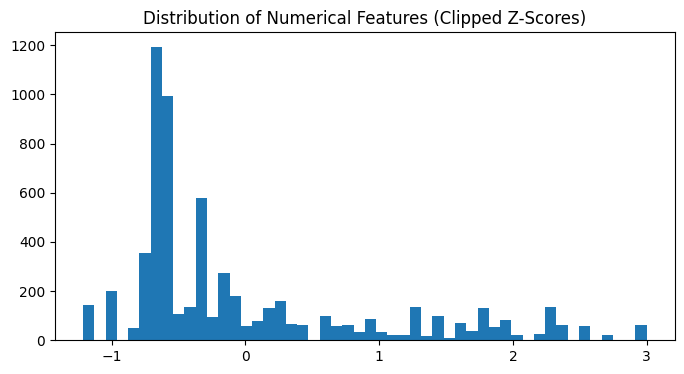

In [12]:
# Numerical values corresponding to the features
num_values = train_data.x_num[sample_idx, d_out:]

print("--- Sample Numerical Values (Standardized) ---")
print(num_values[:5])

plt.figure(figsize=(8, 4))
plt.hist(train_data.x_num[:, d_out:].flatten(), bins=50)
plt.title("Distribution of Numerical Features (Clipped Z-Scores)")
plt.show()

## 🗄️ Step 5: Exploring the HDF5 Corpus

Finally, let's look at how all this is packed into the `.h5` file for efficient training.

In [13]:
if os.path.exists(CORPUS_PATH):
    with h5py.File(CORPUS_PATH, 'r') as f:
        print(f"Corpus File: {CORPUS_PATH}")
        print("\nDatasets included in the corpus:")
        for name in f.keys():
            group = f[name]
            print(f"- {name}")
            print(f"  |-- Task Type: {group.attrs['task_type']}")
            print(f"  |-- Samples: {group['labels'].shape[0]}")
            print(f"  |-- Features: {group.attrs['n_features']}")
else:
    print(f"⚠️ Corpus file not found at {CORPUS_PATH}. Please run the generation script first.")

Corpus File: c:\Users\issa\dev\TFM\nanoTabStar\data\pretrain_corpus_tabstar.h5

Datasets included in the corpus:
- BIN_FINANCIAL_ADULT_INCOME
  |-- Task Type: classification
  |-- Samples: 48842
  |-- Features: 14
- BIN_FINANCIAL_CREDIT_GERMAN
  |-- Task Type: classification
  |-- Samples: 1000
  |-- Features: 20
- BIN_HEALTHCARE_BREAST_CANCER_WISCONSIN
  |-- Task Type: classification
  |-- Samples: 699
  |-- Features: 9
- REG_HOUSES_CALIFORNIA_HOUSES
  |-- Task Type: regression
  |-- Samples: 20640
  |-- Features: 8
- REG_SCIENCE_CONCRETE_COMPRESSIVE_STRENGTH
  |-- Task Type: regression
  |-- Samples: 1030
  |-- Features: 8


## 💡 Conclusion

By storing **raw strings** and **normalized numbers**, we've created a flexible foundation. 
- **Students** can easily inspect the data.
- **Researchers** can swap tokenizers (E5, BERT, etc.) without re-processing the whole dataset.
- **The Model** gets the best of both worlds: semantic context from text and precise magnitude from numerical values.